# Using NZRA Data as Targets

We have refined the AI task to better reflect how the model will be used at inference time. The task is as follows:

#### Context Sets
1. Gridded context: ERA5, Himawari 8, sun position.
2. Offgrid context: Ground station observations.
3. Auxiliary: Topography, x1x2 encoding, land/sea mask.

#### Target Sets:
1. Points from NZRA, sampled at random locations.
2. (tbc) held-out station observations.

This is the first experiment which we are developing & running on the NIWA HPC.

In [1]:
%load_ext autoreload

In [2]:
# imports from this repo
%autoreload 2
from convcnp_assim_nz.config.env_loader import use_absolute_filepaths, get_env_var
from convcnp_assim_nz.utils.variables.var_names import *
from convcnp_assim_nz.utils.variables.coord_names import *
from convcnp_assim_nz.data_processing.nzra_processor import ProcessNZRA
from convcnp_assim_nz.data_processing.topography_processor import ProcessTopography
from convcnp_assim_nz.data_processing.himawari8_processor import ProcessHimawari8
from convcnp_assim_nz.data_processing.era5_processor import ProcessERA5
from convcnp_assim_nz.data_processing.conversions.scalar_conversions import kelvin_to_celsius
from convcnp_assim_nz.data_processing.auxiliary.sun_position import get_sun_culmination, get_sun_position

Loading environment variables from: /esi/project/niwa00004/crowelenn/dev/convcnp-assim-nz/.env


In [3]:
# imports from external libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from deepsensor.train.train import set_gpu_default_device
import deepsensor.torch

In [4]:
# variables for this experiment

dev = True # only use small datasets while in dev

years = [2017]
target_variable = TEMPERATURE

if not dev: # no GPU available on dev node
    set_gpu_default_device()

use_absolute_filepaths(True)


In [5]:
topography_processor = ProcessTopography()
nzra_processor = ProcessNZRA()
era5_processor = ProcessERA5()
h8_processor = ProcessHimawari8()

In [6]:
# load datasets
topography_ds = topography_processor.load_ds()
nzra_ds = nzra_processor.load_ds(years=years)
h8_ds = h8_processor.load_ds(years=years)
era5_ds = era5_processor.load_ds(years=years)

In [7]:
# make small subsets for the dev environment
if dev:
    nzra_ds = nzra_ds.isel(time=slice(0, 48))
    h8_ds   = h8_ds.isel(time=slice(0, 48))
    era5_ds = era5_ds.isel(time=slice(0, 48))

    TOPO_COARSEN = 5
else:
    TOPO_COARSEN = 1

In [8]:
# clean-up NZRA
if TEMPERATURE in nzra_ds.data_vars:
    nzra_ds[TEMPERATURE] = kelvin_to_celsius(nzra_ds[TEMPERATURE])

if TEMPERATURE in era5_ds.data_vars:
    era5_ds[TEMPERATURE] = kelvin_to_celsius(era5_ds[TEMPERATURE])

In [9]:
# process the ERA5 data
era5_ds = era5_ds.isel(level=-1) # select nearest to surface level (geopotential == 1000) only

# add sun angle and culmination to ERA5 dataset
era5_ds[SUN_CULMINATION] = get_sun_culmination(era5_ds.coords)
era5_ds[SUN_ANGLE] = get_sun_position(era5_ds.coords)

In [10]:
# build auxiliary dataset
ds_aux = topography_processor.compute_tpi(topography_ds, window_sizes=[0.1])
ds_aux = ds_aux.reindex({LATITUDE: nzra_ds[LATITUDE], LONGITUDE: nzra_ds[LONGITUDE]}, method='nearest') # expand to the NZRA grid

ds_aux[LAND_SEA_MASK] = ds_aux[ELEVATION].where(ds_aux[ELEVATION].isnull(), 1, 0).fillna(0)

ds_aux_coarse  = ds_aux.coarsen(
    lat=TOPO_COARSEN, 
    lon=TOPO_COARSEN, 
    boundary='trim').mean()

In [11]:
ds_aux = ds_aux.fillna(0)
ds_aux_coarse = ds_aux_coarse.fillna(0)

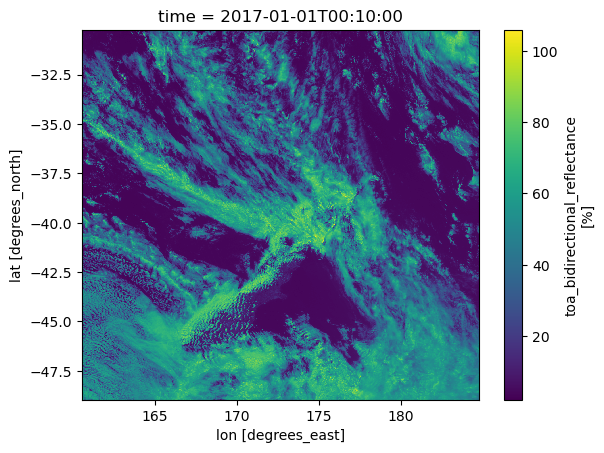

In [12]:
# build himawari8 dataset
h8_ds.isel(time=0)[BAND_3].plot()

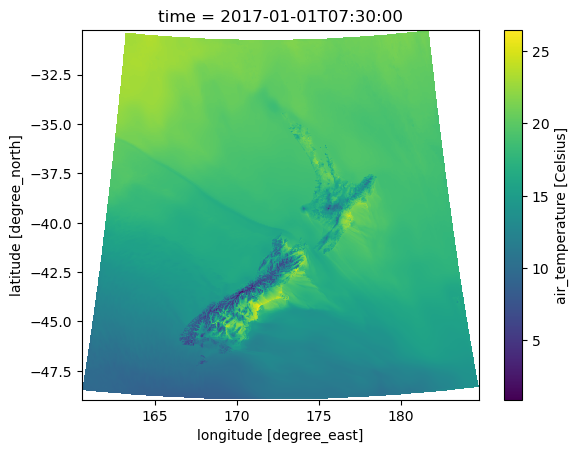

In [13]:
nzra_ds[target_variable].isel(time=9).plot()

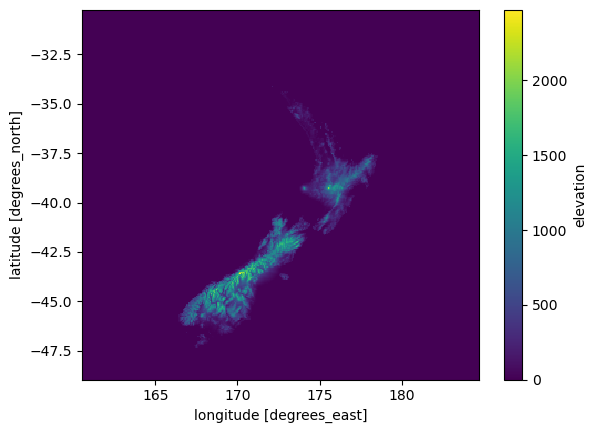

In [14]:
ds_aux_coarse[ELEVATION].plot()

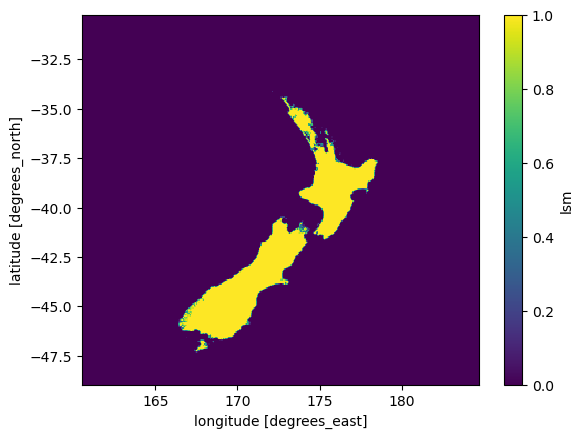

In [15]:
ds_aux_coarse[LAND_SEA_MASK].plot()

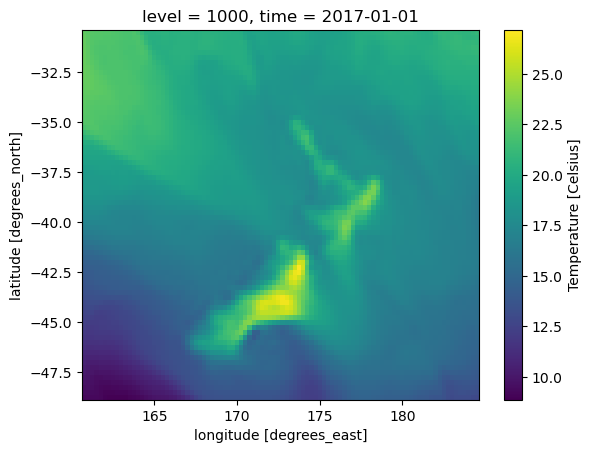

In [16]:
era5_ds[TEMPERATURE].isel(time=0).plot()

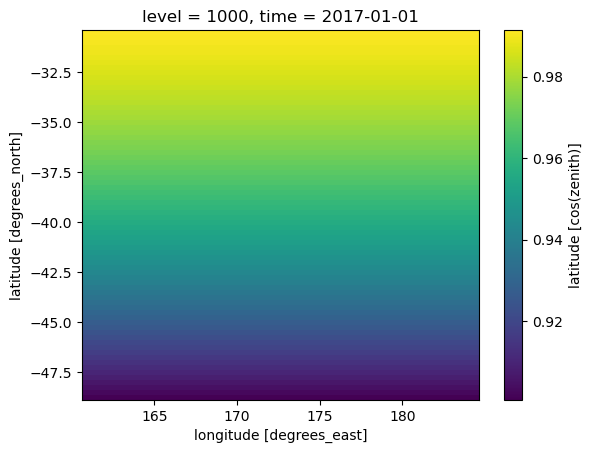

In [17]:
era5_ds[SUN_CULMINATION].isel(time=0).plot()

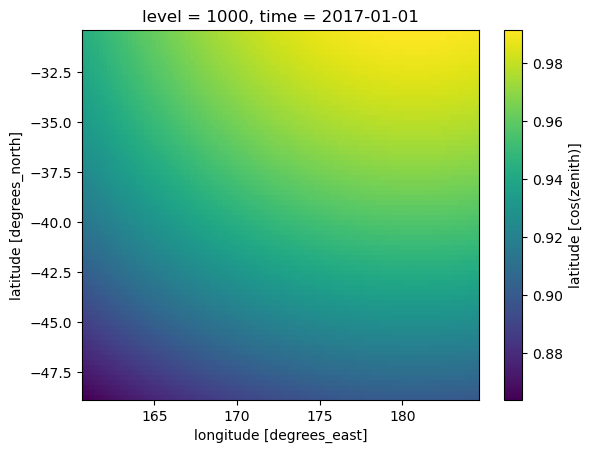

In [18]:
era5_ds[SUN_ANGLE].isel(time=0).plot()